## FONDECYT - Estudiando EOD

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dython.nominal import cramers_v, theils_u, associations
from sklearn.ensemble import ExtraTreesClassifier

# Por alguna razon no puedo configuar bien el texto usando esta linea
#sns.set(context='notebook', style='whitegrid', palette='Accent', font='Fira Sans')
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
%matplotlib inline


# --------------------------------------- #

def normalize_dataframe(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def read_parameters(column):
    return pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/'+column+'.csv', sep=';', index_col='Id', encoding= 'unicode_escape')

def remove_outliers(df, column):
    q1 = df[column].quantile(.15)
    q3 = df[column].quantile(.85)
    iqr = q3-q1
    return  df.pipe(lambda x: x[x[column].between(q1-1.5*iqr,q3+1.5*iqr)])

def plot_bar_categorical(df,categorical_1, categorical_2, sorted_by=None, drop_na=False, plot_text=True, print_stats=True):
    if drop_na:
        _df = df[[categorical_1,categorical_2]].dropna()
    else:
        _df  = df[[categorical_1,categorical_2]].fillna("No responde")
    if _df[categorical_1].dtype != 'object':
        if len(_df[categorical_1].unique())<100:
            _df[categorical_1] = _df[categorical_1].astype(np.int)
        else:
            raise TypeError("{} does not look like a categorical column".format(categorical_1))
    if _df[categorical_2].dtype != 'object':
        if len(_df[categorical_2].unique())<100:
            _df[categorical_2] = _df[categorical_2].astype(np.int)
        else:
            raise TypeError("{} does not look like a categorical column".format(categorical_2))

    df_normalized = _df.groupby([categorical_1, categorical_2]).size().unstack().fillna(0)
    if sorted_by==None:
        sorted_by = df_normalized.columns[0]
    print("(Sorting DataFrame by {})\n".format(sorted_by))
    if print_stats:
        print(_df[categorical_1].value_counts(normalize=True),'\n')
        print(_df[categorical_2].value_counts(normalize=True),'\n')
    df_normalized  = normalize_dataframe(df_normalized).sort_values(sorted_by, ascending=True)
    if len(df[categorical_1].unique())<10:
        kind = 'barh'
        rotation = 0
        y_delta = 0.5
    else:
        kind = 'bar'
        rotation = 60
        y_delta = 0.25
    ax = df_normalized.plot(kind=kind, stacked=True, width=0.8, legend=False, figsize=(14,7), cmap='viridis', edgecolor='none')
    if plot_text:
        patch_handles = ax.get_children()
        percentages = df_normalized.values.T.flatten()*100
        for i in range(len(patch_handles)):
            patch = patch_handles[i]
            if isinstance(patch, mpl.patches.Rectangle):
                if percentages[i]==0:
                    continue
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = y_delta*patch.get_height() + bl[1]
                text = ax.text(x,y, "%d%%" % (percentages[i]), ha='center', color='white', rotation=rotation, fontsize=14,
                               fontweight = 'semibold')
                text.set_path_effects([path_effects.Stroke(linewidth=0.7, foreground='black')])
            else:
                break
    sns.despine()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    #plt.ylim(0,1)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, method='pearson'):
    au_corr = df.corr(method=method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


def time_mapping(time):
    if 5 < time <= 6.5:
        return 'early_morning'
    elif 6.5 < time <= 7.5:
        return 'morning_peak_hour_1'
    elif 7.5 < time <= 9.:
        return 'morning_peak_hour2'
    elif 9. < time < 12:
        return 'morning'
    elif 12 <= time <= 15:
        return 'afternoon_lunch_time'
    elif 15 < time <= 17.5:
        return 'afternoon'
    elif 17.5 < time <= 19:
        return 'afternoon_peak_hour_1'
    elif 19 < time <= 21:
        return 'afternoon_peak_hour_2'
    else:
        return 'night'
    
mode_mapping = {
    'Bip!': 'public',
    'Auto': 'motorized',
    'Caminata': 'non_motorized',
    'Bicicleta': 'non_motorized',
    'Bip! - Otros Público': 'taxi_public',
    'Taxi Colectivo': 'share_taxi',
    'Bip! - Otros Privado': 'taxi_public',
    'Taxi': 'motorized'
}

def estudio_mapping(e):
    if e==1:
        return 'Ninguno'
    elif e<=4:
        return 'Primaria'
    elif e<=7:
        return 'Secundaria'
    elif e<=10:
        return 'Superior (no Universitaria)'
    else:
        return 'Universitaria'
    
def add_period(trips, start, end, name):
    index_values = pd.DatetimeIndex(trips.start_datetime).indexer_between_time(start, end)
    trips['period'].iloc[index_values] = name

def add_periods(df):
    df['period'] = 'n/a'
    add_period(df, '6:01', '7:30:59', 'morning_peak_1')
    add_period(df, '7:31', '9:00:59', 'morning_peak_2')
    add_period(df, '9:01', '12:00:59', 'morning_valley')
    add_period(df, '12:01', '17:30:59', 'afternoon_valley')
    add_period(df, '17:31', '20:30:59', 'afternoon_peak')
    add_period(df, '20:31', '23:00:59', 'night_valley')
    add_period(df, '23:01', '23:59:59', 'night')
    add_period(df, '0:00', '6:00:59', 'night')
    return df

In [5]:
urban_zones = gpd.read_file('json/urban_zones_2016.json')
urban_municipalities = set(urban_zones.Comuna.unique())
person = pd.read_csv('./2012_eod_stgo/EOD_STGO/personas.csv', sep=';', decimal=',', index_col=['Persona', 'Hogar'])
eod = pd.read_csv('./2012_eod_stgo/EOD_STGO/viajes.csv', encoding='iso-8859-1', sep=';', index_col='Viaje', decimal=',').join(person, on=['Persona', 'Hogar'])
distances = pd.read_csv('./2012_eod_stgo/EOD_STGO/DistanciaViaje.csv', sep=';', encoding='iso-8859-1', index_col='Viaje')
hogares = pd.read_csv('./2012_eod_stgo/EOD_STGO/Hogares.csv', encoding='iso-8859-1', sep=';', index_col='Hogar', decimal=',')

purposes = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Proposito.csv', sep=';', index_col='Id')
modes = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/ModoDifusion.csv', sep=';', encoding='iso-8859-1', index_col='ID')
sectors = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Sector.csv', sep=';', encoding='utf-8', index_col='Sector')
comunas = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Comunas.csv', sep=',', encoding='utf-8', index_col='Id')

mode_per_trip = (pd.read_csv('./2012_eod_stgo/EOD_STGO/ViajesDifusion.csv', sep=';', index_col='Viaje')
                .join(modes.rename(columns={'ModoDifusion': 'mode_of_transportation'}), on='ModoDifusion'))


In [6]:
trip_features = (eod.join(distances)
 .pipe(lambda x: x[(x['Imputada'] == 0) & (~x.SectorOrigen.isin([0, 7, 9])) & (~x.SectorDestino.isin([0, 7, 9]))])
 .join(purposes.rename(columns={'Proposito': 'purpose'}), on='Proposito')
 .join(mode_per_trip[['mode_of_transportation']])
 .assign(distance=lambda x: x['DistEuclidiana'] / 1000)
 .pipe(lambda x: x[x.distance.between(0.5, 50)])
 .pipe(lambda x: x[x.AnoNac < 1995])
 .pipe(lambda x: x[x.mode_of_transportation != 'Otros'])
 #.pipe(lambda x: x[x.purpose.isin(['Al trabajo', 'Al estudio', 'volver a casa'])])
 .pipe(lambda x: x[pd.notnull(x.FactorLaboralNormal) & pd.notnull(x.Factor_LaboralNormal)])
 .join(comunas.rename(columns={'Comuna': 'municipality_origin'}), on='ComunaOrigen')
 .join(comunas.rename(columns={'Comuna': 'municipality_destination'}), on='ComunaDestino')
 .pipe(lambda x: x[x.municipality_origin.isin(urban_municipalities) & x.municipality_destination.isin(urban_municipalities)])
 .assign(weight=lambda x: x['FactorLaboralNormal'] * x['Factor_LaboralNormal'])
 .assign(mode_of_transportation=lambda x: x['mode_of_transportation'].map(lambda m: mode_mapping[m]))
 .assign(sector_origin=lambda x: x['SectorOrigen'].astype(np.int))
 .assign(sector_destination=lambda x: x['SectorDestino'].astype(np.int))
 .join(hogares[['DiaAsig']], on='Hogar')
 .assign(Educacion= lambda x: x['Estudios'].map(lambda e: estudio_mapping(e)))
)

# Agrego el sufijo _desc, lo que se refiere a descripcion
trip_features = (trip_features
                 .join(read_parameters('TramoIngreso'), on='TramoIngresoFinal', rsuffix='_desc')
                 .join(read_parameters('TiempoMedio'), on='TiempoMedio', rsuffix='_desc')
                 .join(read_parameters('Estudios'), on='Estudios', rsuffix='_desc')
                 .join(read_parameters('Ocupacion').rename(columns={'ocupacion': 'Ocupacion_desc'}), on='Ocupacion', )
                )
#trip_features['Ocupacion_desc'].fillna('No responde', inplace=True) 
#trip_features['TramoIngreso_desc'].fillna('No responde', inplace=True)
#trip_features['Estudios'].fillna('No responde', inplace=True)

print(trip_features.shape, trip_features.weight.sum())

trip_features['HoraIni'] = pd.to_timedelta(trip_features['HoraIni'] + ':00')
#trip_features = trip_features[pd.notnull(trip_features['HoraIni'])]
trip_features['HoraInicio'] = trip_features['HoraIni'] / pd.Timedelta(hours=1)
#trip_features['HoraFin'] = pd.to_timedelta(trip_features['HoraFin'] + ':00')
#trip_features = trip_features[pd.notnull(trip_features['HoraFin'])]
#trip_features['HoraFinal'] = trip_features['HoraFin'] / pd.Timedelta(hours=1)
trip_features = (trip_features
 .assign(TramoHoraInicio_desc = lambda x : x['HoraInicio'].map(lambda t: time_mapping(t))
                ))

trip_features['start_datetime'] = pd.to_datetime(trip_features.HoraIni)
trip_features = add_periods(trip_features).drop('start_datetime', axis=1)
trip_features.head()

(40864, 88) 9286619.37863329


TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [ ]:
home_data = pd.read_csv('./2012_eod_stgo/EOD_STGO/Hogares.csv', sep=';', decimal=',')
def weighted_mean(df, value, weight):
    weighted_sum = (df[value] * df[weight]).sum()
    return weighted_sum / df[weight].sum()
zone_income = np.log(home_data.groupby('Zona').apply(lambda x: weighted_mean(x, 'IngresoHogar', 'Factor')))
zone_income.name = 'mean_home_income'
pd.DataFrame(zone_income).to_csv('2017_results/zone_income.csv.gz', compression='gzip')
zone_centroids = urban_zones.to_crs({'init': 'epsg:5361'}).set_index('ID').centroid
zone_positions = np.vstack([zone_centroids.geometry.x, zone_centroids.geometry.y]).T
from scipy.spatial.distance import pdist, squareform
zone_distance_matrix = squareform(pdist(zone_positions)) / 1000
zone_distance_pairs = pd.DataFrame(zone_distance_matrix, 
             index=list(zone_centroids.index), 
             columns=list(zone_centroids.index)).unstack().reset_index()
zone_distance_pairs.columns = ['ZonaOrigen', 'ZonaDestino', 'distance']
zone_distance_pairs = zone_distance_pairs.set_index(['ZonaOrigen', 'ZonaDestino'])
zone_distance_pairs.to_csv('2017_results/zone_distances.csv.gz', compression='gzip')
trip_features = (trip_features
                  .join(zone_income, on='ZonaOrigen', how='inner')
                  .rename({'mean_home_income': 'origin_income'}, axis=1)
                  .join(zone_income, on='ZonaDestino', how='inner')
                  .rename({'mean_home_income': 'destination_income'}, axis=1)
                  .pipe(lambda x: x[x['ZonaOrigen']!=x['ZonaDestino']])
                 )#[['distance', 'mode_of_transportation', 'origin_income', 'destination_income', 'weight', 'period']])
trip_features.head()

In [7]:
trip_features.columns

Index(['Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'AnoNac', 'Sexo',
       'Relacion', 'Viajes', 'LicenciaConducir', 'PaseEscolar', 'AdultoMayor',
       'Estudios', 'Curso', 'Actividad', 'Ocupacion', 'ActividadEmpresa',
       'JornadaTrabajo', 'DondeEstudia', 'DirActividadCoordX',
       'DirActividadCoordY', 'DirEstudiosCoordX', 'DirEstudiosCoordY',
       'NoViaja', 'TarjetaBip', 'Tarjeta2Bip', 'MedioViajeRestricion',
       'C

In [8]:
mindist_df = pd.read_csv('2020_results/mindist_zonahogar.csv')
#mindist_df = pd.read_csv('data_distances/mindist.csvwi').set_index('Viaje').join(trip_features[['ZonaOrigen', 'ZonaDestino']])
#mindist_zonaorigen =mindist_df.groupby(['ZonaOrigen'])['origen_mindist_taxi', 'origen_mindist_stop', 'origen_mindist_metro'].median()
#mindist_zonadestino =mindist_df.groupby(['ZonaDestino'])['destino_mindist_taxi', 'destino_mindist_stop', 'destino_mindist_metro'].median()
mindist_df.head()

FileNotFoundError: [Errno 2] File 2020_results/mindist_zonahogar.csv does not exist: '2020_results/mindist_zonahogar.csv'

In [7]:
#trip_features = trip_features.join(mindist_zonaorigen, on='ZonaOrigen').join(mindist_zonadestino, on='ZonaDestino')

trip_features = (trip_features.join(mindist_df.groupby('Zona').mean().add_prefix('origen_'), on='ZonaOrigen')
                              .join(mindist_df.groupby('Zona').mean().add_prefix('destino_'), on='ZonaDestino')
                )

In [9]:
trip_features2 = trip_features
trip_features2 = trip_features2.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)), axis=0, result_type='expand')

In [15]:
X = trip_features2[['distance', #'education_zone_origin', 'education_zone_destination', #'IngresoMedio_ComunaOrigen', 'IngresoMedio_ComunaDestino',
                    'origen_mindist_taxi', 'origen_mindist_stop', 'origen_mindist_metro',
                    'destino_mindist_taxi', 'destino_mindist_stop', 'destino_mindist_metro',
                    'origin_income', 'destination_income']]#, 'taxi_cnt', 'metro_cnt', 'stops_cnt']]
y = trip_features2['mode_of_transportation']

#X = trip_features2.drop(columns=['mode_of_transportation'])

Feature ranking:
1. feature 0 (distance) (0.31921)
2. feature 7 (origin_income) (0.09395)
3. feature 8 (destination_income) (0.09353)
4. feature 3 (origen_mindist_metro) (0.08780)
5. feature 6 (destino_mindist_metro) (0.08779)
6. feature 2 (origen_mindist_stop) (0.08261)
7. feature 5 (destino_mindist_stop) (0.08046)
8. feature 1 (origen_mindist_taxi) (0.07764)
9. feature 4 (destino_mindist_taxi) (0.07701)


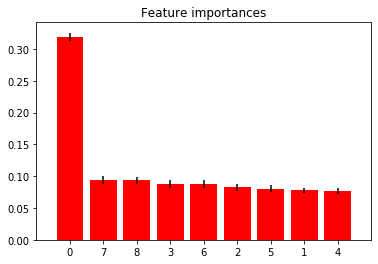

In [16]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(importances.shape[0]):
    print("{}. feature {} ({}) ({:.5f})".format(f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(importances.shape[0]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(importances.shape[0]), indices)
plt.xlim([-1, importances.shape[0]])
plt.show()


Al parecer hacer un *Feature Selection* con clasificadores como `ExtraTree` o `RandomForest` da una buena impresión de cuales son las columnas importantes

## Training the Model

In [17]:
#formula = 'C(mode_of_transportation) ~ distance + C(IngresoMedio_ComunaOrigen) + C(IngresoMedio_ComunaDestino) + C(period)' #C(TramoIngreso_ComunaOrigen)'
#formula = 'C(mode_of_transportation) ~ distance + origin_income + destination_income +  C(period)'
formula = 'C(mode_of_transportation) ~ distance + origin_income + destination_income + origen_mindist_taxi + origen_mindist_metro + origen_mindist_stop + destino_mindist_taxi + destino_mindist_metro + destino_mindist_stop + C(period)'

In [18]:
mnlogit_model = smf.mnlogit(formula, trip_features, freq_weights=trip_features['weight'])
model_results = mnlogit_model.fit()
model_results.summary()

Optimization terminated successfully.
         Current function value: 0.985478
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                38806
Model:                        MNLogit   Df Residuals:                    38742
Method:                           MLE   Df Model:                           60
Date:                Mon, 04 May 2020   Pseudo R-squ.:                  0.1919
Time:                        21:55:36   Log-Likelihood:                -38242.
converged:                       True   LL-Null:                       -47322.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
y=C(mode_of_transportation)[non_motorized]       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     20.4793      0.659     31.083      0.000      19.188      21.771
C(period)[T.afternoon_valley]                 -0.0389      0.054     -0.726      0.468      -0.144       0.066
C(period)[T.morning_peak_1]                   -0.2271      0.085     -2.660      0.008      -0.394      -0.060
C(period)[T.morning_peak_2]                   -0.1384      0.065     -2.115      0.034      -0.267      -0.010
C(period)[T.morning_valley]                    0.0045      0.063      0.072      0.943      -0.119       0.128
C(period)[T.night]                            -0.6340      0.154     -4.113      0.000      -0.936      -0.332
C(period)[T.night_valley]                     -0.5295      0.095     -5.593      0.000      -0.715      -0.344
distance                                      -0.7525      0.014    -53.185      0.000      -0.780      -0.725
origin_income                                 -0.6975      0.048    -14.499      0.000      -0.792      -0.603
destination_income                            -0.6952      0.048    -14.472      0.000      -0.789      -0.601
origen_mindist_taxi                          -10.1073      5.407     -1.869      0.062     -20.704       0.490
origen_mindist_metro                          -5.9881      1.789     -3.346      0.001      -9.495      -2.481
origen_mindist_stop                           24.1543      8.083      2.988      0.003       8.312      39.996
destino_mindist_taxi                         -11.7110      5.393     -2.171      0.030     -22.281      -1.141
destino_mindist_metro                         -4.8058      1.790     -2.684      0.007      -8.315      -1.297
destino_mindist_stop                          22.7409      8.149      2.791      0.005       6.769      38.713
--------------------------------------------------------------------------------------------------------------
y=C(mode_of_transportation)[public]       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              20.0993      0.460     43.676      0.000      19.197      21.001
C(period)[T.afternoon_valley]           0.1528      0.036      4.267      0.000       0.083       0.223
C(period)[T.morning_peak_1]             0.2539      0.046      5.532      0.000       0.164       0.344
C(period)[T.morning_peak_2]             0.0877      0.043      2.028      0.043       0.003       0.173
C(period)[T.morning_valley]             0.2694      0.044      6.136      0.000       0.183       0.355
C(period)[T.night]                     -0.2193      0.073     -3.015      0.003      -0.362      -0.077
C(period)[T.night_valley]              -0.2963      0.058     -5.098      0.000      -0.410      -0.182
distance                                0.0970      0.002     39.441      0.000       0

In [14]:
# Me sigue explotando el notebook en esta parte xD

#marginal_effects = model_results.get_margeff()
#marginal_effects.summary()

In [15]:
import json
# sadly statsmodels doesn't save this. presumably it's in alphabetical order, but it's better to check.
column_names = ['motorized', 'non_motorized', 'public', 'shared_taxi', 'taxi_public']

with open('2020_results/mnlogit_column_names.json', 'wt') as f:
    json.dump(column_names, f)
# --------------------------------------- #

In [43]:
import joblib

joblib.dump(model_results, '2020_results/mnlogit_zone_model_instance.joblib.gz')

['2020_results/mnlogit_zone_model_instance.joblib.gz']

In [16]:
predictions = model_results.predict(trip_features)
predictions.columns = column_names
predictions['model_mode'] = predictions.idxmax(axis=1)
predictions = predictions.join(trip_features.municipality_origin)
predictions.model_mode.unique()

array(['motorized', 'public', 'non_motorized', 'shared_taxi',
       'taxi_public'], dtype=object)

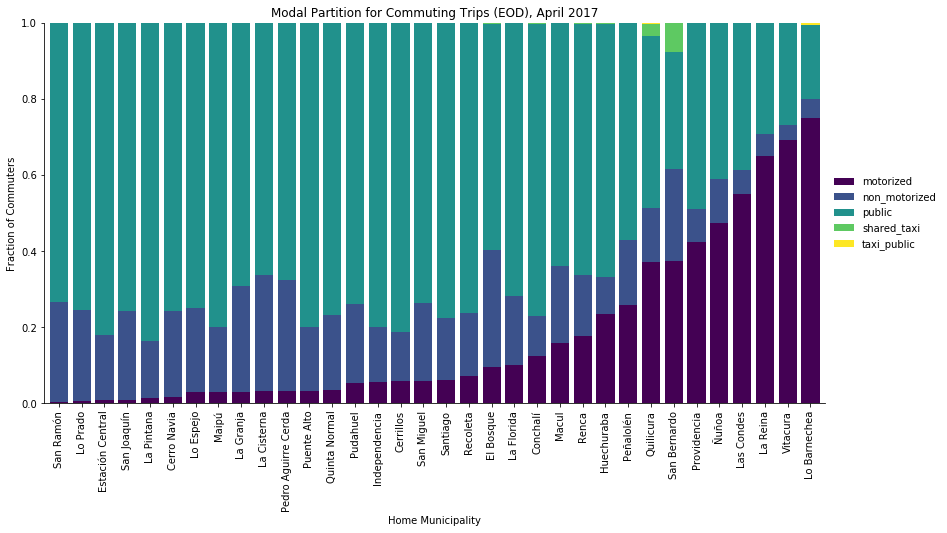

In [17]:
modal_partition = predictions.groupby(['municipality_origin', 'model_mode']).size().reset_index()
modal_partition = modal_partition.pivot_table(index='municipality_origin', columns='model_mode').fillna(0)
modal_partition = pd.DataFrame(normalize(modal_partition, norm='l1'), index=modal_partition.index, columns=modal_partition.columns.levels[1])
modal_partition

ax = (modal_partition.sort_values('motorized')
 #.pipe(lambda x: x.loc[:,label_order].copy())
 .plot(kind='bar', stacked=True, width=0.8, legend=False, figsize=(14,7), cmap='viridis', edgecolor='none')
)
patch_handles = ax.get_children()
percentages = modal_partition.sort_values('motorized').values.T.flatten()*100
for i in range(len(patch_handles)):
    patch = patch_handles[i]
    if isinstance(patch, mpl.patches.Rectangle):
        if percentages[i]==0:
            continue
        bl = patch.get_xy()
        #x = 0.5*patch.get_width() + bl[0]
        #y = 0.25*patch.get_height() + bl[1]
        #text = ax.text(x,y, "%d%%" % (percentages[i]), ha='center', color='white', rotation=45, fontsize=14,
        #               fontweight = 'semibold')
        #text.set_path_effects([path_effects.Stroke(linewidth=0.7, foreground='black')])
    else:
        break

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.xlabel('')
plt.ylabel('Fraction of Commuters')
plt.xlabel('Home Municipality')
plt.title('Modal Partition for Commuting Trips (EOD), April 2017')
plt.ylim([0, 1])
sns.despine()

(Sorting DataFrame by motorized)



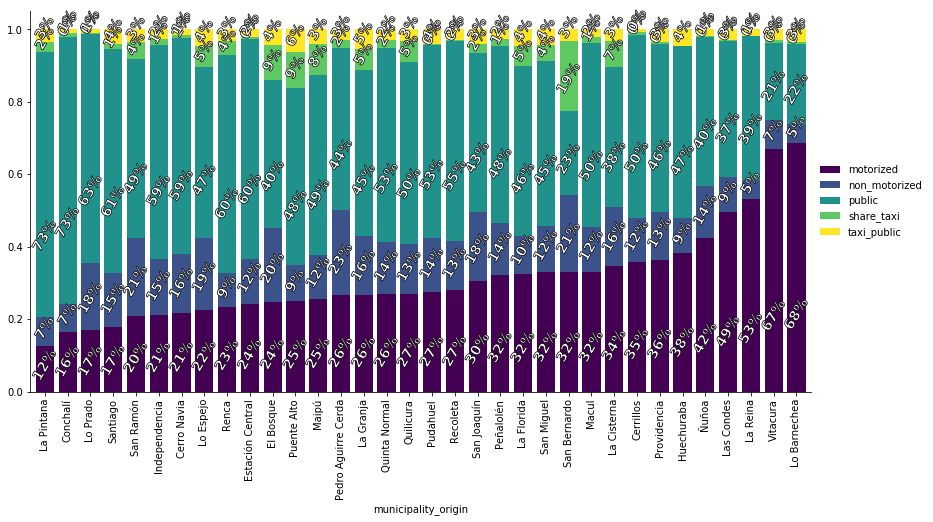

In [46]:
plot_bar_categorical(trip_features , 'municipality_origin', 'mode_of_transportation', plot_text=True, print_stats=False) #'mode_of_transportation'

In [29]:
import joblib

joblib.dump(model_results, '2020_results/mnlogit_zone_model_instance.joblib.gz')

['2020_results/mnlogit_zone_model_instance.joblib.gz']

In [51]:
predictions.join(trip_features[['ZonaOrigen', 'ZonaDestino']]).set_index(['ZonaOrigen', 'ZonaDestino'])

motorized  non_motorized    public  share_taxi  \
ZonaOrigen ZonaDestino                                                   
400        407           0.474885       0.023890  0.460859    0.040366   
           407           0.516260       0.027570  0.423713    0.032456   
           407           0.359781       0.021876  0.568511    0.049833   
           410           0.294077       0.166277  0.472367    0.067280   
           20            0.213968       0.000014  0.781589    0.004429   
...                           ...            ...       ...         ...   
257        770           0.222256       0.155727  0.413442    0.208574   
           118           0.355213       0.191638  0.382527    0.070622   
632        639           0.064671       0.231785  0.529235    0.174309   
           196           0.094606       0.092583  0.607073    0.205738   
782        107           0.987271       0.000031  0.012590    0.000108   

                       model_mode municipality_origin  
ZonaOrigen ZonaDestino                                 
400        407          motorized               Maipú  
           407          motorized               Maipú  
           407             public               Maipú  
           410             public               Maipú  
           20              public               Maipú  
...                           ...                 ...  
257        770             public          La Pintana  
           118             public          La Pintana  
632        639             public         San Joaquín  
           196             public         San Joaquín  
782        107          motorized        San Bernardo  

[39284 rows x 6 columns]

In [44]:
predictions.drop(columns=['model_mode', 'municipality_origin']).to_csv('2020_results/prior_04042020.csv')

In [49]:
trip_features.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,destino_mindist_stop,destino_mindist_metro,taxi_cnt,metro_cnt,stops_cnt,IngresoMedio_ComunaOrigen,IngresoMedio_ComunaDestino,TramoIngreso_ComunaOrigen,education_zone_origin,education_zone_destination
0,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,0.001196,0.017259,5.0,0.0,23.0,239060,239060,None,Secundaria,Secundaria
1,176071,17607101,1,94.0,94.0,2.0,2.0,400,407,335193.9688,...,0.002660,0.007725,5.0,0.0,23.0,239060,239060,Ingreso entre 250000 y 300000,Secundaria,Secundaria
2,185103,18510301,1,94.0,94.0,2.0,2.0,400,407,335231.0938,...,0.001731,0.012187,5.0,0.0,23.0,239060,239060,Ingreso entre 200000 y 250000,Secundaria,Secundaria
3,173901,17390101,1,94.0,94.0,2.0,2.0,400,410,335624.0000,...,0.000447,0.001009,5.0,0.0,23.0,239060,239060,Ingreso entre 0 y 200000,Secundaria,Secundaria
4,174491,17449101,2,94.0,70.0,2.0,4.0,400,20,335511.3438,...,0.001289,0.000351,5.0,0.0,23.0,239060,317528,None,Secundaria,Secundaria
